## Деревья. Случайный лес

#### 1. Основы построения решающего дерева

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**1.1 Расчет энтропии распределения классов:**

Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$.

In [ ]:
probabilities = np.array([8/10, 2/10])
entropy = round(-np.sum(probabilities * np.log(probabilities)), 2)
entropy

0.5

**1.2 Расчет критерия информативности:**

Пусть дополнительно известно, что вершина не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$.

Формула критерия информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

В качестве $H(R)$ индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов.

In [ ]:
gini_rm = 8/10 * (1 - 8/10) + 2/10 * (1 - 2/10)
gini_rl = 8/8 * (1 - 8/8) + 0/8 * (1 - 0/8)                                       # на самом деле можно было не считать критерий джини в левом и правом поддереве
gini_rr = 0/2 * (1 - 0/2) + 2/2 * (1 - 2/2)                                       # и так было понятно, что раз в каждое из них попали все объекты каждого класса
                                                                                  # то "хаотичность" (неопределенность) в каждом из них будет нулевая
q = round(gini_rm - 8/10 * gini_rl - 2/10 * gini_rr, 2)
q

0.32

In [ ]:
probabilities_rm = np.array([8/10, 2/10])
probabilities_rl = np.array([8/8, 0/8])
probabilities_rr = np.array([0/2, 2/2])
rm, rl, rr = 10, 8, 2

def gini(probabilities_r):
  return np.sum(probabilities_r * (1 - probabilities_r))

q = round(gini(probabilities_rm) - rl/rm * gini(probabilities_rl) - rr/rm * gini(probabilities_rr), 2)
q

0.32

**1.3 Подсчет предсказаний модели для задачи регрессии:**

Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47].

In [ ]:
# предсказание в листовой вершине будет равно среднему значению ответов на объектах, попавших в нее
targets = [1, 10, 5, 18, 100, 30, 50, 61, 84, 47]
prediction = sum(targets) / len(targets)
prediction

40.6

#### 2. Решающие деревья

Написание и тестирование собственной реализации решающего дерева.

In [ ]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**2.1 Реализация функции `find_best_split()`, которая находит оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием**

Для категориальных признаков применяется наивный алгоритм разбиения: пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое.

In [ ]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
) -> Tuple[np.ndarray, np.ndarray, float, float]:
    """
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * При одинаковых приростах Джини или дисперсии выбирается минимальный сплит.

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """
    if np.all(feature_vector == feature_vector[0]):                               # если признак константный, то не буду искать уникальные значения, а просто запомню весь вектор
      feature_vector_sorted = feature_vector
    else:
      feature_vector_sorted = np.sort(np.unique(feature_vector))                  # для поиска порогов отсортирую уникальные значения признака

    # сначала найду пороги
    if feature_type == 'real':                                                    # для вещественного признака
      def thresholds_real(a, b):
        return (a + b)/2
      vfunc = np.vectorize(thresholds_real)
      thresholds = vfunc(feature_vector_sorted[:-1], feature_vector_sorted[1:])   # подсчет средних значений соседних элементов в отсортированном векторе значений признака

    elif feature_type == 'categorical':                                           # для категориального признака пороги - сами категории
      thresholds = feature_vector_sorted

    # далее буду разбивать вершину и считать критерий информативности
    def Q(R_m, y_m, task, feature_type, t):

    # разобью вершину в зависимости от типа признака
      # если признак вещественный
      if feature_type == 'real':                                                  # для вещественного признака
        R_l, R_r = R_m[R_m < t], R_m[R_m >= t]                                    # разбиваю вектор признака по порогу
        y_l, y_r = y_m[R_m < t], y_m[R_m >= t]                                    # в зависимости от разбиения вектора признака разбиваю так же и вектор с ответами

      # если признак категориальный
      elif feature_type == 'categorical':
        R_l, R_r = R_m[R_m == t], R_m[R_m != t]                                   # разбиваю так, что в левой части будет только одна категория
        y_l, y_r = y_m[R_m == t], y_m[R_m != t]

      # после разбиения посчитаю критерий информативности (в зависимости от задачи)
      def H(R, task):
        if task == 'regression':                                                  # если задача регрессии, то хаотичность измеряется дисперсией ответов в вершине
          return np.var(R)

        elif task == 'classification':                                            # если задача классификации, то считаю критерий джини
          counter = Counter(R)                                                    # для этого нахожу вероятности классов в вершине
          counts = list(counter.values())
          def calc_prob(count):
            return count/sum(counts)
          probabilities = np.array(list(map(calc_prob, counts)))
          return np.sum(probabilities * (1 - probabilities))

      H_m = H(y_m, task)

      H_l = H(y_l, task)
      H_r = H(y_r, task)


      return H_m - len(R_l) / len(R_m) * H_l - len(R_r) / len(R_m) * H_r

    Q_vectorized = np.vectorize(Q, excluded=['R_m', 'y_m'])
    ginis = Q_vectorized(R_m=feature_vector, y_m=target_vector, task=task, feature_type=feature_type, t=thresholds)
    threshold_best = thresholds[np.argmax(ginis)]
    gini_best = max(ginis)
    return thresholds, ginis, threshold_best, gini_best

In [ ]:
# сделаю небольшую проверку для двух случаев
# 1 случай: задача регрессии с вещественным признаком
feature_vector = np.array([3,4,2,5,1,6])
target_vector = np.array([1,2,5,3,7,6])
print(find_best_split(feature_vector, target_vector, task='regression', feature_type='real'))
print()

R_m = np.array([3,4,2,5,1,6])
y_m = np.array([1,2,5,3,7,6])
t = 2.5
y_l = np.array([5,7])
y_r = np.array([1,2,3,6])
print(np.var(y_m) - len(y_l) / len(y_m) * np.var(y_l) - len(y_r) / len(y_m) * np.var(y_r))

(array([1.5, 2.5, 3.5, 4.5, 5.5]), array([1.8       , 2.        , 0.11111111, 0.125     , 0.8       ]), 2.5, 2.000000000000001)

2.000000000000001


In [ ]:
# 2 случай: задача двухклассовой классификации с вещественным признаком
feature_vector = np.array([1,2,3,4,5,6])
target_vector = np.array([0,1,1,0,1,1])
print(find_best_split(feature_vector, target_vector, task='classification', feature_type='real'))
print()

R_m = np.array([1,2,3,4,5,6])
y_m = np.array([0,1,1,0,1,1])
gini_m = 2/6 * (1 - 2/6) + 4/6 * (1 - 4/6)
t = 1.5
y_l = np.array([0])
gini_l = 0
y_r = np.array([1,1,0,1,1])
gini_r = 1/5 * (1 - 1/5) + 4/5 * (1 - 4/5)
print(gini_m - len(y_l) / len(y_m) * gini_l - len(y_r) / len(y_m) * gini_r)

(array([1.5, 2.5, 3.5, 4.5, 5.5]), array([0.17777778, 0.02777778, 0.        , 0.11111111, 0.04444444]), 1.5, 0.1777777777777778)

0.1777777777777778


Тестирование функции на датасете `California`.

In [ ]:
from sklearn.datasets import fetch_california_housing

In [ ]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


In [ ]:
y

array([4.526, 3.585, 3.521, ..., 0.923, 0.847, 0.894])

Построение графика зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [ ]:
thresholds, Q_array, threshold_best, Q_best = find_best_split(X['MedInc'], y, task='regression')

In [ ]:
print(thresholds)
print(Q_array)
print(threshold_best)
print(Q_best)

[ 0.51795  0.54275  0.5964  ... 14.7421  14.95045 15.00005]
[0.0001088  0.0001856  0.0002249  ... 0.0199786  0.01956096 0.01872587]
5.03515
0.4127513862016769


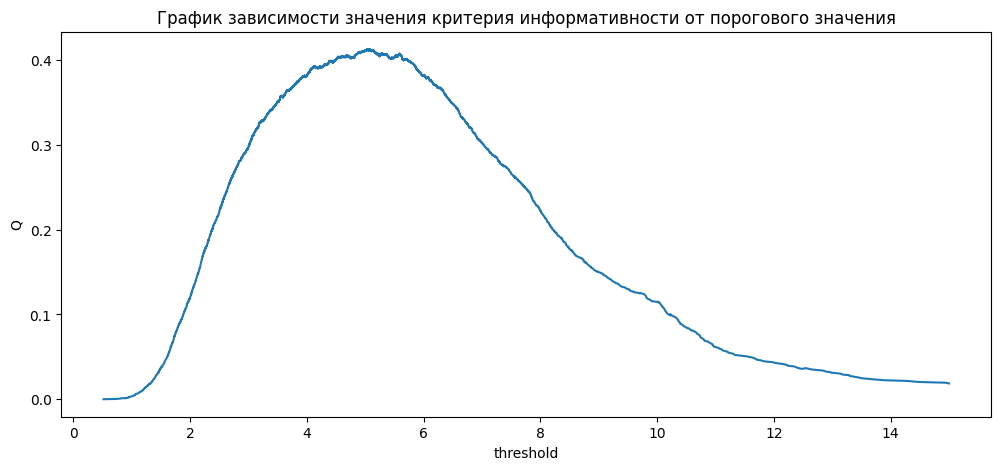

In [ ]:
plt.figure(figsize=(12, 5))
plt.plot(thresholds, Q_array)
plt.title('График зависимости значения критерия информативности от порогового значения')
plt.xlabel("threshold")
plt.ylabel("Q")
plt.show()

Поиск лучшего предиката первой вершины решающего дерева.

In [ ]:
splits = X.apply(find_best_split, axis=0, args=(y, 'regression'))

In [ ]:
splits

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,"[0.51795, 0.5427500000000001, 0.5964, 0.6604, ...","[1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5, 9.5, ...","[0.8675213675213675, 0.9444444444444444, 1.065...","[0.35416666666666663, 0.4097222222222222, 0.47...","[4.0, 5.5, 7.0, 8.5, 10.0, 12.0, 13.5, 14.5, 1...","[0.7211538461538461, 0.8602941176470589, 1.015...","[32.545, 32.555, 32.565, 32.575, 32.585, 32.59...","[-124.32499999999999, -124.285, -124.265, -124..."
1,"[0.00010880339847707532, 0.0001855959365471005...","[7.585249523445192e-05, 4.668203886115663e-05,...","[9.532625096619896e-06, 4.6615266393157384e-05...","[2.2499295940558994e-05, 3.0005573329550117e-0...","[9.927931175335303e-05, 0.00010815673438302476...","[7.432658259709513e-05, 9.01349621829084e-07, ...","[9.409391785619725e-05, 0.0002071640493266358,...","[6.105609976225779e-05, 0.00018296853368338084..."
2,5.03515,51.5,6.374305,1.103378,1160.5,3.112543,37.935,-121.865
3,0.412751,0.030901,0.159208,0.015253,0.002831,0.073919,0.090334,0.050211


In [ ]:
features = splits.columns.to_list()
thresholds = splits.loc[2].values
Q_array = splits.loc[3].values

In [ ]:
Q_best = Q_array[np.argmax(Q_array)]
threshold_best = thresholds[np.argmax(Q_array)]
feature_best = features[np.argmax(Q_array)]
print('Лучший критерий информативности:', Q_best)
print('Лучший порог:', threshold_best)
print('Лучший признак:', feature_best)

# лучший предикат [X['MedInc'] < 5.03515]

Лучший критерий информативности: 0.4127513862016769
Лучший порог: 5.03515
Лучший признак: MedInc


**2.2 Реализация класса решающего дерева**

Построение дерева осуществляется согласно базовому жадному алгоритму.
- **Выбор лучшего разбиения** производится по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

In [ ]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = feature_vector < threshold_best
                elif feature_type == "categorical":
                    # в данной реализации это просто значение категории
                    threshold_best = threshold
                    split = feature_vector == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """
        if node['type'] == 'terminal':
          return node['class']

        if self._feature_types[node['feature_split']] == 'real':
          if x[node['feature_split']] < node['threshold']:
            return self._predict_node(x, node['left_child'])
          return self._predict_node(x, node['right_child'])

        elif self._feature_types[node['feature_split']] == 'categorical':
          if x[node['feature_split']] == node['category_split']:
            return self._predict_node(x, node['left_child'])
          return self._predict_node(x, node['right_child'])

    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**2.3 Работа с датасетом: построение кривых "порог — значение критерия Джини" для признаков, визуализация диаграммы рассеяния "значение признака — класс"**

Датасет: `08_trees_rf.csv` (преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). Признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1).

In [ ]:
data = pd.read_csv('08_trees_rf_data.csv')
data = data.drop(['Unnamed: 0'], axis=1)
data.head()

,STG,SCG,STR,LPR,PEG,UNS
0,0.00,0.00,0.00,0.00,0.00,0
1,0.08,0.08,0.10,0.24,0.90,1
2,0.06,0.06,0.05,0.25,0.33,0
3,0.10,0.10,0.15,0.65,0.30,1
4,0.08,0.08,0.08,0.98,0.24,0


In [ ]:
y = np.array(data['UNS'])
data = data.drop(['UNS'], axis=1)

In [ ]:
splits = data.apply(find_best_split, axis=0, args=(y, 'classification'))

In [ ]:
splits

,STG,SCG,STR,LPR,PEG
0,"[0.01, 0.03, 0.045, 0.055, 0.07, 0.08499999999...","[0.005, 0.0125, 0.0175, 0.03, 0.045, 0.055, 0....","[0.01, 0.025, 0.035, 0.045, 0.055, 0.065, 0.07...","[0.005, 0.015, 0.03, 0.05, 0.07, 0.08499999999...","[0.005, 0.02, 0.035, 0.045, 0.0600000000000000..."
1,"[0.0001136124631933022, 0.001493476424281659, ...","[0.0001136124631933022, 0.001493476424281659, ...","[0.0026657005095239716, 8.574469505195914e-06,...","[0.0026657005095239716, 0.001493476424281659, ...","[0.005352226804278604, 0.010788740644844974, 0..."
2,0.615,0.425,0.365,0.39,0.3365
3,0.031481,0.020438,0.018119,0.030789,0.399392


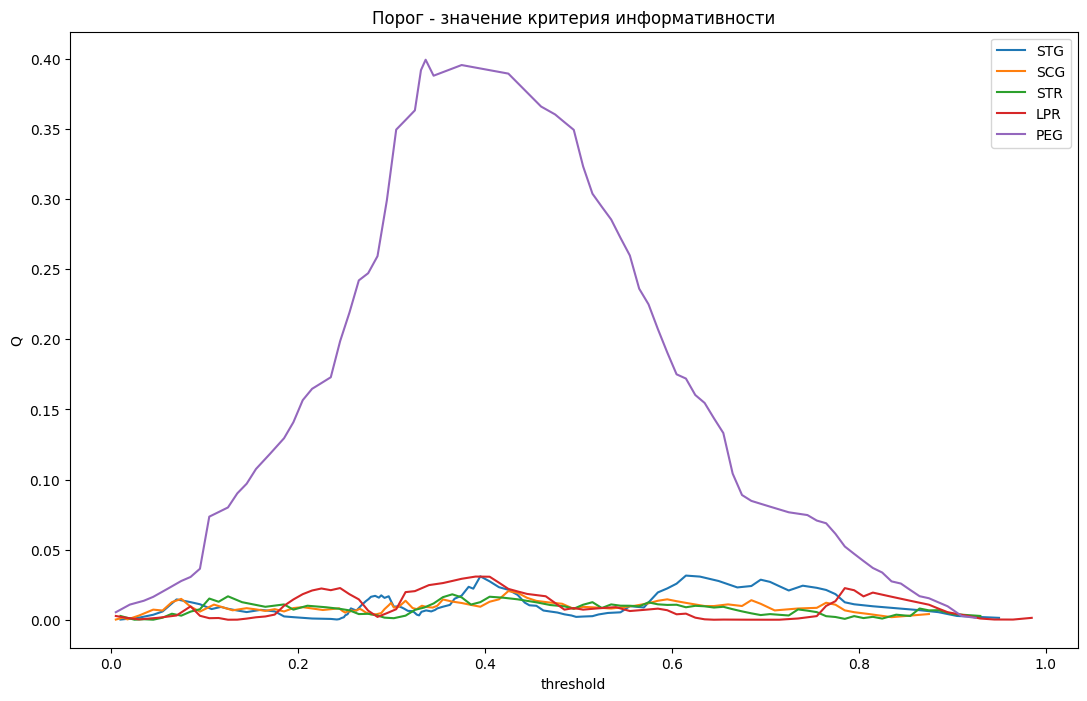

In [ ]:
plt.figure(figsize=(13, 8))
plt.title('Порог - значение критерия информативности')
plt.plot(splits.at[0, 'STG'], splits.at[1, 'STG'])
plt.plot(splits.at[0, 'SCG'], splits.at[1, 'SCG'])
plt.plot(splits.at[0, 'STR'], splits.at[1, 'STR'])
plt.plot(splits.at[0, 'LPR'], splits.at[1, 'LPR'])
plt.plot(splits.at[0, 'PEG'], splits.at[1, 'PEG'])
plt.xlabel("threshold")
plt.ylabel("Q")
plt.legend(['STG', 'SCG', 'STR', 'LPR', 'PEG'])
plt.show()

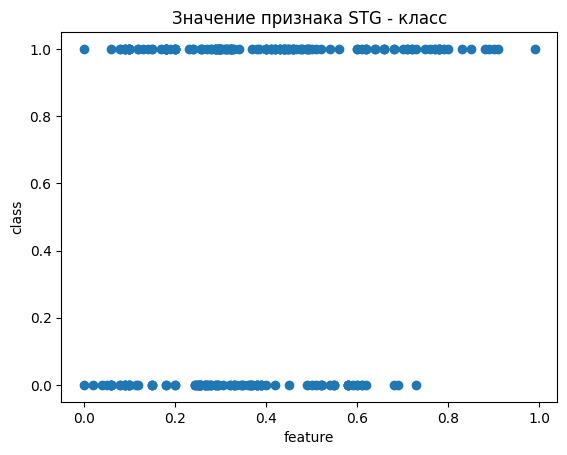

In [ ]:
plt.scatter(data['STG'], y)
plt.title('Значение признака STG - класс')
plt.xlabel("feature")
plt.ylabel("class")
plt.show()

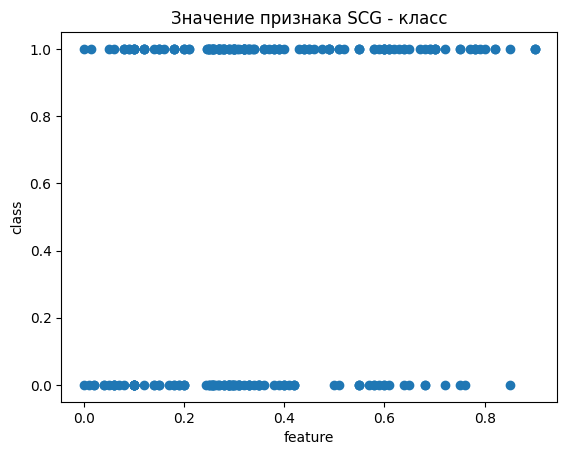

In [ ]:
plt.scatter(data['SCG'], y)
plt.title('Значение признака SCG - класс')
plt.xlabel("feature")
plt.ylabel("class")
plt.show()

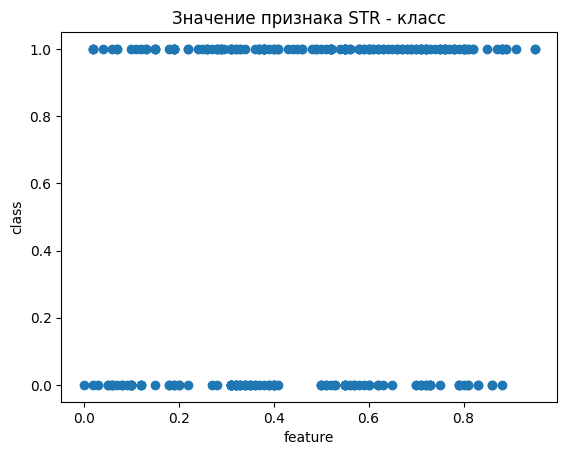

In [ ]:
plt.scatter(data['STR'], y)
plt.title('Значение признака STR - класс')
plt.xlabel("feature")
plt.ylabel("class")
plt.show()

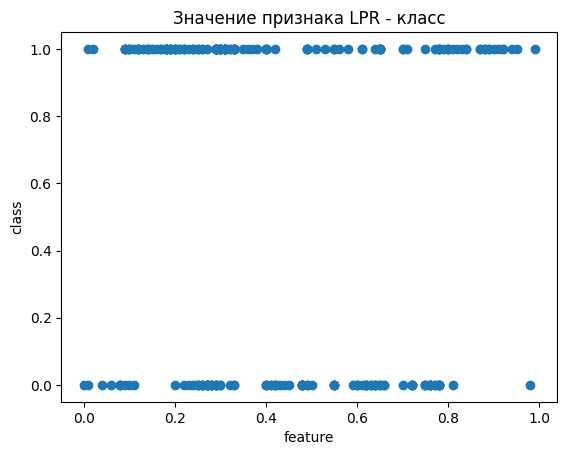

In [ ]:
plt.scatter(data['LPR'], y)
plt.title('Значение признака LPR - класс')
plt.xlabel("feature")
plt.ylabel("class")
plt.show()

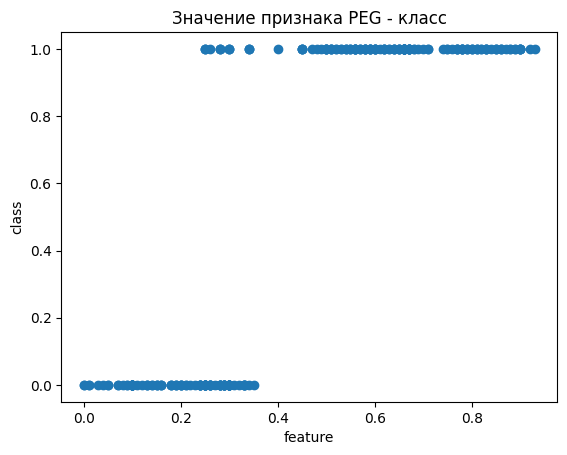

In [ ]:
plt.scatter(data['PEG'], y)
plt.title('Значение признака PEG - класс')
plt.xlabel("feature")
plt.ylabel("class")
plt.show()

Исходя из кривых значений критерия Джини, поскольку максимальное значение имеет критерий информативности на признаке 'PEG', по нему нужно производить деление выборки на два поддерева. Данный результат согласуется с визуальной оценкой диаграмм рассеяиния: на диаграмме последнего признака явно видно, что объекты с низким значением признака (меньше 0.3365) в основном относятся к классу 0, а со значением повыше - к классу 1.

Если посмотреть на кривые зависимости критерия информативности от порога, то видно, что для всех признаков, кроме последнего, критерий информативности не сильно меняется с изменением порога, он остается в одном диапазоне для всех этих признаков (примерно от 0. до 0.05 - признаки, по которым деление практически невозможно). А вот для признака PEG он сначала растет, а потом падает ("хороший" признак, по которому выборка делится почти идеально).

**2.4 Тестирование реализованного решающего дерева на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom), таблица `agaricus-lepiota.data`**

Первый столбец — целевая переменная (e — edible, p — poisonous).

In [ ]:
data = pd.read_csv('08_trees_rf.data')

In [ ]:
data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g


Обработка категориальных признаков.

In [ ]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
data = data.apply(label_encoder.fit_transform, axis=0) # применение к каждому столбцу для преобразования строковых имен категорий в натуральные числа
data.head()

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,0,5,2,9,1,0,1,0,0,4,...,2,7,7,0,2,1,4,3,2,1
1,0,0,2,8,1,3,1,0,0,5,...,2,7,7,0,2,1,4,3,2,3
2,1,5,3,8,1,6,1,0,1,5,...,2,7,7,0,2,1,4,2,3,5
3,0,5,2,3,0,5,1,1,0,4,...,2,7,7,0,2,1,0,3,0,1
4,0,5,3,9,1,0,1,0,0,5,...,2,7,7,0,2,1,4,2,2,1


In [ ]:
y = data['p']
data = data.drop(['p'], axis=1)

Обучение решающего дерева на половине случайно выбранных объектов и предсказания для оставшейся половины.

In [ ]:
from sklearn.model_selection import train_test_split
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.5, random_state=42)

In [ ]:
feature_types = ['categorical'] * len(data.columns)

In [ ]:
tree = DecisionTree(feature_types=feature_types)
tree.fit(data_train.values, np.array(y_train))

In [ ]:
predictions = tree.predict(data_test.values)

In [ ]:
def accuracy(y_test, predictions):
  return np.sum(y_test == predictions) / len(y_test)
accuracy(y_test, predictions)

1.0

#### 3. Бэггинг и случайный лес

Решение [задачи предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data).

In [ ]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [ ]:
data = pd.read_csv('08_trees_rf_data_1.csv')
print(f"Dataset shape: {data.shape}")
data.head()

Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Распределение целевой переменной:

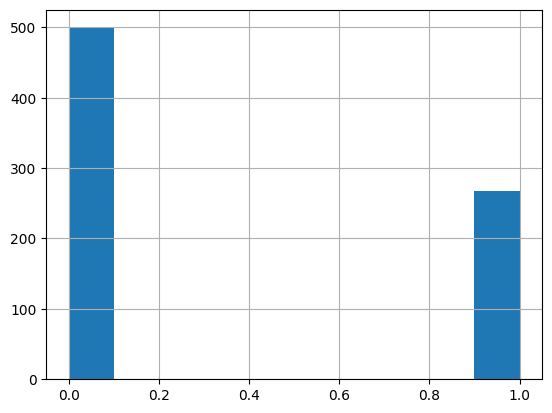

In [ ]:
data['Outcome'].hist()
plt.show()

**3.1 Подготовка данных**

In [ ]:
y = data['Outcome']
data = data.drop(['Outcome'], axis=1)

In [ ]:
# разбиение датасета на обучающую и тестовую части в отношении 7:3
data_train, data_test, y_train, y_test = train_test_split(data, y, test_size=0.3, random_state=42)

In [ ]:
# разделение обучающей выборки на обучающую-обучающую и обучающую-валидационную в соотношении 7:3
data_train_train, data_train_validate, y_train_train, y_train_validate = train_test_split(data_train, y_train, test_size=0.3, random_state=42)

# обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета)

**3.2 Подбор оптимальных значений гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`**

In [ ]:
# списки с возможными значениями для перебора
max_depth_array = [max_depth for max_depth in range(1, 10)]
min_samples_leaf_array = [min_samples_leaf for min_samples_leaf in range(1, 10)]

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1_score_array = []
max_depth_min_samples_leaf_array = []

# для каждой пары значений
for max_depth in max_depth_array:

  for min_samples_leaf in min_samples_leaf_array:

    dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    # обучение дерева на обучающей-обучающей выборке
    dt.fit(data_train_train, y_train_train)

    # определение качества на обучающей-валидационной выборке
    f1_score_array.append(f1_score(y_train_validate, dt.predict(data_train_validate)))
    max_depth_min_samples_leaf_array.append((max_depth, min_samples_leaf))

# выбор пары значений, которая даёт наилучшее качество на обучающей-валидационной выборке
best_max_depth = max_depth_min_samples_leaf_array[np.argmax(f1_score_array)][0]
best_min_samples_leaf = max_depth_min_samples_leaf_array[np.argmax(f1_score_array)][1]
best_f1_score = f1_score_array[np.argmax(f1_score_array)]

print('Лучшая глубина:', best_max_depth)
print('Минимальное число объектов в листе:', best_min_samples_leaf)
print('f1-мера:', best_f1_score)

Лучшая глубина: 7
Минимальное число объектов в листе: 7
f1-мера: 0.7142857142857143


Обучение решающего дерева с подобранными гиперпараметрами на **полной обучающей** выборке. Оценка качества классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [ ]:
dt = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
dt.fit(data_train, y_train)

predictions = dt.predict(data_test)

print('Accuracy on test:', accuracy_score(y_test, predictions))
print('Precision on test:', precision_score(y_test, predictions))
print('Recall on test:', recall_score(y_test, predictions))
print('AUC_ROC on test:', roc_auc_score(y_test, predictions))
# доля верных ответов, полнота и площадь под ROC-кривой неплохие, точность похуже

Accuracy on test: 0.696969696969697
Precision on test: 0.5555555555555556
Recall on test: 0.625
AUC_ROC on test: 0.6800496688741722


**3.3 Обучение [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на полной обучающей выборке. Оценка качества классификации на тестовой выборке**

In [ ]:
base_tree = DecisionTreeClassifier(random_state=42)
bag = BaggingClassifier(base_tree, n_estimators=50, random_state=42)
bag.fit(data_train, y_train)

predictions = bag.predict(data_test)

print('Accuracy on test:', accuracy_score(y_test, predictions))
print('Precision on test:', precision_score(y_test, predictions))
print('Recall on test:', recall_score(y_test, predictions))
print('AUC_ROC on test:', roc_auc_score(y_test, predictions))

Accuracy on test: 0.7489177489177489
Precision on test: 0.6309523809523809
Recall on test: 0.6625
AUC_ROC on test: 0.7286009933774835


In [ ]:
# с оптимальными max_depth и min_samples_leaf
base_tree = DecisionTreeClassifier(max_depth=best_max_depth, min_samples_leaf=best_min_samples_leaf, random_state=42)
bag = BaggingClassifier(base_tree, n_estimators=50, random_state=42)
bag.fit(data_train, y_train)

predictions = bag.predict(data_test)

print('Accuracy on test:', accuracy_score(y_test, predictions))
print('Precision on test:', precision_score(y_test, predictions))
print('Recall on test:', recall_score(y_test, predictions))
print('AUC_ROC on test:', roc_auc_score(y_test, predictions))

# в обоих случаях все метрики подросли

Accuracy on test: 0.7575757575757576
Precision on test: 0.6463414634146342
Recall on test: 0.6625
AUC_ROC on test: 0.7352235099337749


**3.4 Кросс-валидация на полной обучающей выборке и подбор оптимальных значений гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями**

In [ ]:
# списки с возможными значениями для перебора
max_depth_array = [max_depth for max_depth in range(1, 10)]
min_samples_leaf_array = [min_samples_leaf for min_samples_leaf in range(1, 10)]

In [ ]:
from sklearn.model_selection import cross_val_score

In [ ]:
f1_scores_CV = []
max_depth_min_samples_leaf_array = []

# для каждой пары значений
for max_depth in max_depth_array:

  for min_samples_leaf in min_samples_leaf_array:

    # кросс-валидация на полной обучающей выборке
    rf = RandomForestClassifier(n_estimators=50, max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
    # усреднение значений критерия по всем прогонам кросс-валидации
    f1_scores_CV.append(np.mean(cross_val_score(rf, data_train, y_train, cv=5, scoring='f1')))
    max_depth_min_samples_leaf_array.append((max_depth, min_samples_leaf))

# выбор пары значений, которая даёт наилучшее среднее качество
best_max_depth_CV = max_depth_min_samples_leaf_array[np.argmax(f1_scores_CV)][0]
best_min_samples_leaf_CV = max_depth_min_samples_leaf_array[np.argmax(f1_scores_CV)][1]
best_f1_score_CV = f1_scores_CV[np.argmax(f1_scores_CV)]

print('Лучшая глубина:', best_max_depth_CV)
print('Минимальное число объектов в листе:', best_min_samples_leaf_CV)
print('f1-мера:', best_f1_score_CV)

Лучшая глубина: 9
Минимальное число объектов в листе: 1
f1-мера: 0.6449713890046731


Обучение случайного леса с подобранными гиперпараметрами на **полной обучающей** выборке. Оценка качества классификации.

In [ ]:
rf_CV = RandomForestClassifier(n_estimators=50, max_depth=best_max_depth_CV, min_samples_leaf=best_min_samples_leaf_CV, random_state=42)
rf_CV.fit(data_train, y_train)

predictions = rf_CV.predict(data_test)

print('Accuracy on test:', accuracy_score(y_test, predictions))
print('Precision on test:', precision_score(y_test, predictions))
print('Recall on test:', recall_score(y_test, predictions))
print('AUC_ROC on test:', roc_auc_score(y_test, predictions))

Accuracy on test: 0.7402597402597403
Precision on test: 0.625
Recall on test: 0.625
AUC_ROC on test: 0.7131622516556292


In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
import warnings
warnings.filterwarnings("default", category=RuntimeWarning)

In [ ]:
# другой способ, результаты те же
params = {'max_depth': max_depth_array, 'min_samples_leaf': min_samples_leaf_array}

rf = RandomForestClassifier(n_estimators=50, random_state=42)

clf_CV = GridSearchCV(rf, params, scoring='f1', cv=5)
clf_CV.fit(data_train, y_train)

predictions = clf_CV.predict(data_test)

print(clf_CV.best_params_, 'best mean f1 score:', clf_CV.best_score_)
print('Accuracy on test:', accuracy_score(y_test, predictions))
print('Precision on test:', precision_score(y_test, predictions))
print('Recall on test:', recall_score(y_test, predictions))
print('AUC_ROC on test:', roc_auc_score(y_test, predictions))

{'max_depth': 9, 'min_samples_leaf': 1} best mean f1 score: 0.6449713890046731
Accuracy on test: 0.7402597402597403
Precision on test: 0.625
Recall on test: 0.625
AUC_ROC on test: 0.7131622516556292


Лучшей моделью оказался BaggingClassifier, обученный на 50 деревьях.

**3.5 Построение графика зависимости AUC-ROC на тестовой выборке от числа деревьев для случайного леса, обучаемого на полной обучающей выборке**

In [ ]:
number_of_trees = [num_of_trees for num_of_trees in range(1, 200)]
AUC_ROCs = []

for num_of_trees in number_of_trees:

  rf = RandomForestClassifier(n_estimators=num_of_trees, random_state=42)
  rf.fit(data_train, y_train)

  predictions = rf.predict(data_test)

  AUC_ROCs.append(roc_auc_score(y_test, predictions))

In [ ]:
print('Лучшая AUC-ROC:', AUC_ROCs[np.argmax(AUC_ROCs)])
print('Число деревьев', number_of_trees[np.argmax(AUC_ROCs)])

Лучшая AUC-ROC: 0.7411009933774835
Число деревьев 11


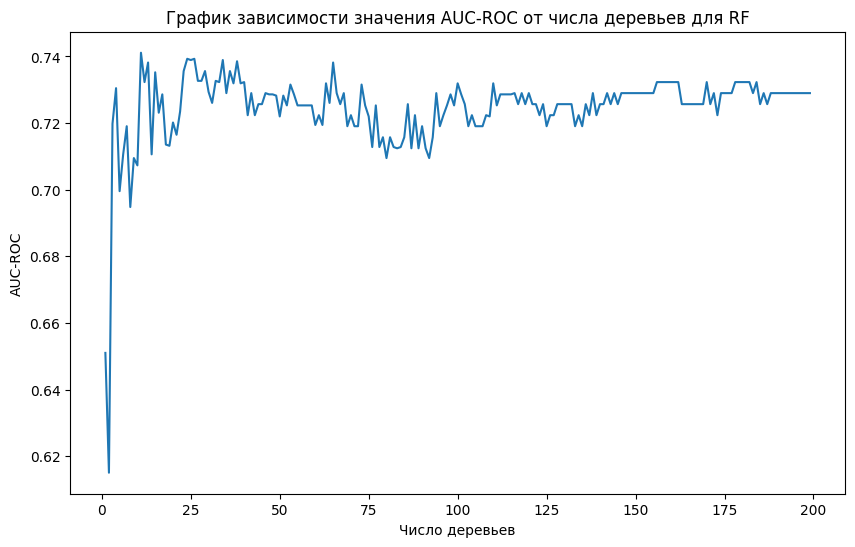

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(number_of_trees, AUC_ROCs)
plt.title('График зависимости значения AUC-ROC от числа деревьев для RF')
plt.xlabel('Число деревьев')
plt.ylabel('AUC-ROC')
plt.show()

Как видно на графике, сначала значение площади под ROC-кривой растет с увеличением числа деревьев в случайном лесу, а затем колеблется в интервале от 0.71 до 0.74, при этом самое лучшее значение достигается при числе деревьев, равном 11. В отличие от MSE, которая будет постоянно только уменьшаться с ростом числа деревьев, AUC-ROC может немного колебаться с ростом числа деревьев.

**3.6 Подсчет важности признаков для лучшей модели случайного леса из п. 3.4**

In [ ]:
pd.DataFrame({"Feature": data.columns, "Importance": rf_CV.feature_importances_}).sort_values(by="Importance", ascending=False).reset_index(drop=True)

,Feature,Importance
0,Glucose,0.290721
1,BMI,0.161252
2,Age,0.143014
3,DiabetesPedigreeFunction,0.108664
4,BloodPressure,0.079312
5,Pregnancies,0.077857
6,Insulin,0.077571
7,SkinThickness,0.061608


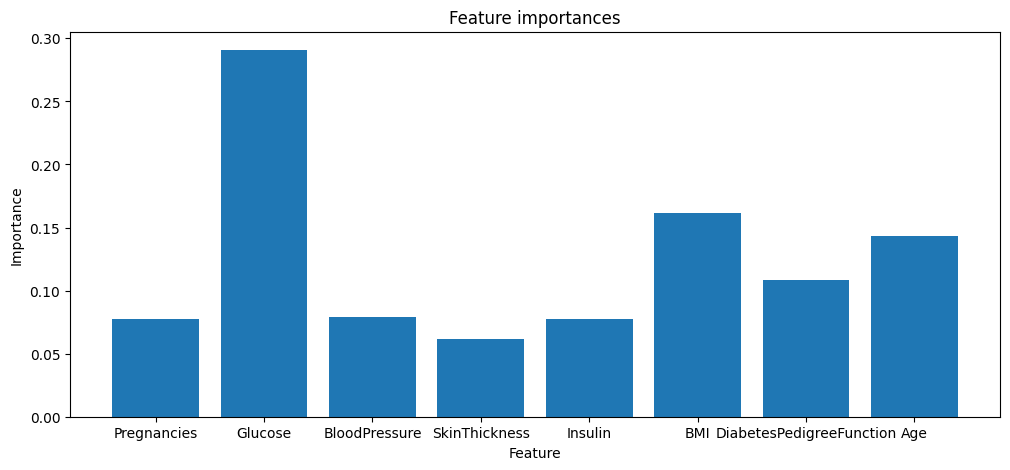

In [ ]:
plt.figure(figsize=(12, 5))
plt.title("Feature importances")
plt.bar(data.columns, rf_CV.feature_importances_)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.show()

# самым важным для определения диабета признаком оказалась концентрация глюкозы в крови

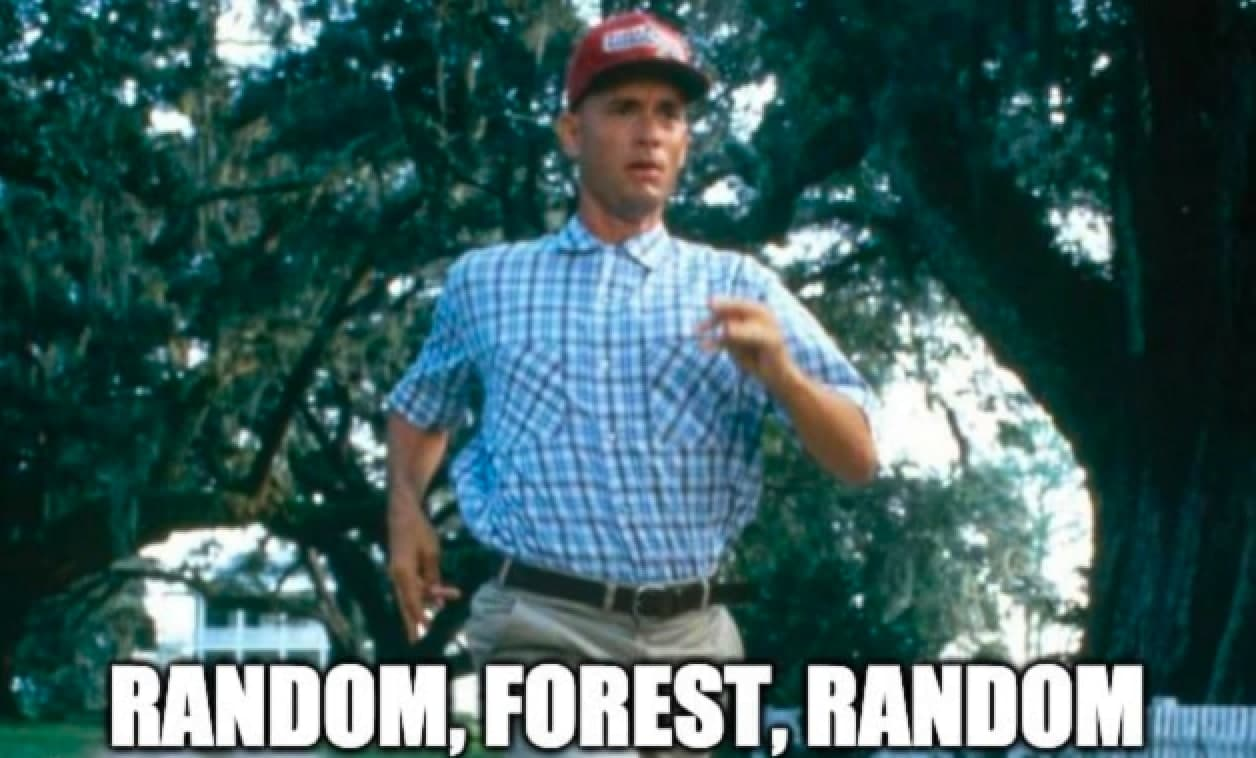